In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
import pandas as pd

data = pd.read_csv("train.csv")

In [3]:
data.head()

,ID,Utterance,Speaker,Dialogue_ID,Target
0,TRAIN_0000,also I was the point person on my company’s tr...,Chandler,0,neutral
1,TRAIN_0001,You must’ve had your hands full.,The Interviewer,0,neutral
2,TRAIN_0002,That I did. That I did.,Chandler,0,neutral
3,TRAIN_0003,So let’s talk a little bit about your duties.,The Interviewer,0,neutral
4,TRAIN_0004,My duties? All right.,Chandler,0,surprise


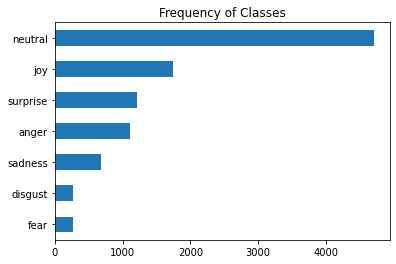

In [4]:
import matplotlib.pyplot as plt

data["Target"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


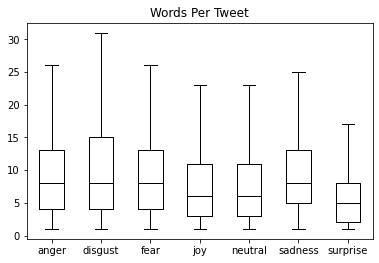

In [5]:
data["Words Per Tweet"] = data["Utterance"].str.split().apply(len)
data.boxplot("Words Per Tweet", by="Target", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [6]:
data['Target'].value_counts(ascending = True)

fear         268
disgust      271
sadness      683
anger       1109
surprise    1205
joy         1743
neutral     4710
Name: Target, dtype: int64

In [7]:
data['label'] = data['Target'].map({'neutral':0,
                                 'joy':1,
                                 'surprise':2,
                                 'anger':3,
                                 'sadness':4,
                                 'disgust':5,
                                 'fear':6})

data = data[['ID','Utterance','label']]

In [8]:
data.head()

,ID,Utterance,label
0,TRAIN_0000,also I was the point person on my company’s tr...,0
1,TRAIN_0001,You must’ve had your hands full.,0
2,TRAIN_0002,That I did. That I did.,0
3,TRAIN_0003,So let’s talk a little bit about your duties.,0
4,TRAIN_0004,My duties? All right.,2


In [9]:
# label 마다 250개씩 추출 

df = pd.DataFrame()

for i in range(len(data["label"].unique())) :
  result = data[data['label']==i].sample(250)
  df = df.append(result,ignore_index = True)

In [10]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size = 0.2, random_state = 42,
                                  stratify = df['label'])

In [11]:
!pip install datasets -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.1 MB/s eta 0:00:00


In [12]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

from datasets.dataset_dict import DatasetDict

raw_data = {
     'train':Dataset.from_dict({'Utterance':train_dataset['Utterance'], 'label' : train_dataset['label']}),
     'val':Dataset.from_dict({'Utterance':val_dataset['Utterance'], 'label' : val_dataset['label']})
     }

raw_data = DatasetDict(raw_data)
     
raw_data

DatasetDict({
    train: Dataset({
        features: ['Utterance', 'label'],
        num_rows: 1400
    })
    val: Dataset({
        features: ['Utterance', 'label'],
        num_rows: 350
    })
})

In [13]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 85.1 MB/s eta 0:00:00


In [14]:
from transformers import AutoTokenizer
# AutoTokenizer : 체크포인트 이름을 사용해 모델의 설정, 사전 훈련된 가중치
#                 어휘사전을 자동으로 추출하는 클래스

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [15]:
tokenizer.vocab_size

30522

In [16]:
tokenizer.model_max_length

512

In [17]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [18]:
# 전체 데이터셋 토큰화하기

def tokenize(batch):
    return tokenizer(batch["Utterance"], padding=True, truncation=True)

# Padding=True : 배치에 있는 가장 긴 샘플 크기에 맞춰 샘플을 0으로 패딩
# truncation=True : 모델의 최대 문맥 크기에 맞춰 샘플을 잘라냄

In [19]:
df_encoded = raw_data.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [20]:
print(df_encoded ['train'].column_names)

['Utterance', 'label', 'input_ids', 'attention_mask']


In [21]:
df_encoded ['train'][:2]

{'Utterance': ["What's with her?", 'Not after this!'],
 'label': [5, 3],
 'input_ids': [[101,
   2054,
   1005,
   1055,
   2007,
   2014,
   1029,
   102,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  [101,
   2025,
   2044,
   2023,
   999,
   102,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,


In [23]:
import torch
from transformers import AutoModel
# AutoModel 클래스는 사전 훈련된 모델의 가중치를 로드, form_pretrained()메서드 사용

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
def extract_hidden_states(batch):
    # 모델 입력을 GPU로 옮깁니다.
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # 마지막 은닉 상태를 추출합니다.
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # [CLS] 토큰에 대한 벡터를 반환합니다.
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [27]:
df_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [28]:
df_encoded

DatasetDict({
    train: Dataset({
        features: ['Utterance', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1400
    })
    val: Dataset({
        features: ['Utterance', 'label', 'input_ids', 'attention_mask'],
        num_rows: 350
    })
})

In [29]:
df_hidden = df_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [30]:
df_hidden["train"]

Dataset({
    features: ['Utterance', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
    num_rows: 1400
})

In [31]:
df_hidden["train"][0]

{'label': tensor(5),
 'input_ids': tensor([ 101, 2054, 1005, 1055, 2007, 2014, 1029,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [32]:
import numpy as np

X_train = np.array(df_hidden["train"]["hidden_state"])
X_valid = np.array(df_hidden["val"]["hidden_state"])
y_train = np.array(df_hidden["train"]["label"])
y_valid = np.array(df_hidden["val"]["label"])
X_train.shape, X_valid.shape

((1400, 768), (350, 768))

In [35]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=7c104e1e2764568a217ec51f42d40786e51f59a478a1f3a0a447a18b3ced274a
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=58936381cb742da17e2d1ea311ceb050b47fc1dfac8deb9003a5121045952e65
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


In [36]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# 특성 스케일을 [0,1] 범위로 조정합니다.
X_scaled = MinMaxScaler().fit_transform(X_train)
# UMAP 객체를 생성하고 훈련시킵니다.
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# 2D 임베딩의 데이터프레임을 만듭니다.
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.069995,4.352097,5
1,1.193490,9.370975,3
2,1.089687,9.303226,5
3,1.498866,9.004577,6
4,2.853885,8.088277,2


In [37]:
df_emb['label'].unique()

array([5, 3, 6, 2, 1, 0, 4])

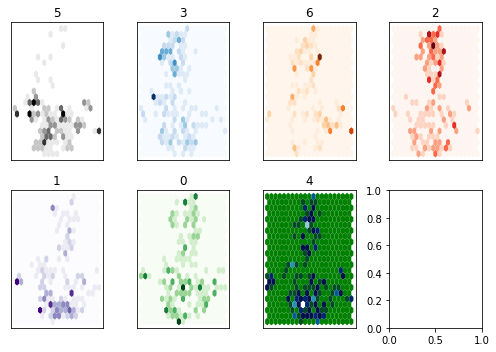

In [38]:
fig, axes = plt.subplots(2, 4, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens","ocean"]
labels = df_emb['label'].unique()

for i, (label, cmap) in enumerate(zip(labels, cmaps)): # zip 함수로 cmaps과 label을 묶음
    df_emb_sub = df_emb.query(f"label == {i}") # df.query : 조건에 부합하는 데이터 추출에 사용
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, # hexbin : 육각형 그리드 형태로 값을 반환하는 그래프
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout() # subplot이 겹치지 않게하는 역할
plt.show()

In [39]:
# 수렴을 보장하기 위해 `max_iter`를 증가시킵니다.
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=300)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.44571428571428573

In [40]:
from sklearn.dummy import DummyClassifier 
# DummyClassifier : 단순 모델 , 항상 다수 클래스를 예측하거나 랜덤한 클래스를 예측하는 모델

dummy_clf = DummyClassifier(strategy = 'most_frequent')
dummy_clf.fit(X_train,y_train)
dummy_clf.score(X_valid, y_valid)

0.14285714285714285

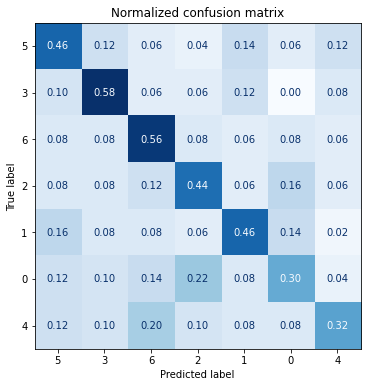

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [42]:
from transformers import AutoModelForSequenceClassification

num_labels = 7
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

In [43]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [50]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(df_encoded["train"]) // batch_size
training_args = TrainingArguments(output_dir='./result',
                                  num_train_epochs=20,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  log_level="error")

In [51]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=df_encoded["train"],
    eval_dataset=df_encoded["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator = data_collator
)

trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.803500,1.738659,0.380000,0.341424
2,1.703700,1.670480,0.402857,0.385098
3,1.593600,1.598333,0.428571,0.413232
4,1.479700,1.554730,0.445714,0.442217
5,1.389000,1.514428,0.462857,0.455578
6,1.255200,1.488686,0.462857,0.461918
7,1.170700,1.489750,0.454286,0.452792
8,1.021300,1.492604,0.451429,0.447830
9,0.910600,1.501144,0.474286,0.472177
10,0.850300,1.525824,0.471429,0.468075


TrainOutput(global_step=440, training_loss=0.8989031661640514, metrics={'train_runtime': 298.935, 'train_samples_per_second': 93.666, 'train_steps_per_second': 1.472, 'total_flos': 688270898280000.0, 'train_loss': 0.8989031661640514, 'epoch': 20.0})

In [52]:
pred_outputs = trainer.predict(df_encoded["val"])

In [55]:
pred_outputs.metrics

{'test_loss': 1.488686203956604,
 'test_accuracy': 0.46285714285714286,
 'test_f1': 0.4619179504100289,
 'test_runtime': 0.7482,
 'test_samples_per_second': 467.796,
 'test_steps_per_second': 8.019}

In [57]:
y_preds = np.argmax(pred_outputs.predictions, axis=1)

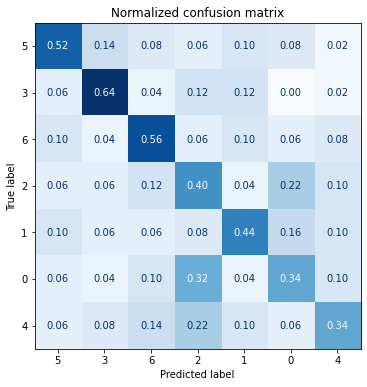

In [58]:
plot_confusion_matrix(y_preds, y_valid,labels)